In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

In [26]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data(file_path):
    data_df = pd.read_csv(file_path, sep=";")
    data_df.sort_values(["Date", "Interval_5"], inplace=True)

    # Vectorize the days
    day_subsets = data_df.groupby("Date")
    vectorized_days = np.array([subset.set_index("Interval_5")["flow"].reindex(range(288)).values
                                for _, subset in day_subsets])

    # Remove days with NaN values
    valid_days = ~np.isnan(vectorized_days).any(axis=1)
    return vectorized_days[valid_days]


In [27]:
# 2. Clustering and Evaluation
def perform_clustering(data, method, params):
    if method == 'KMeans':
        model = KMeans(n_clusters=params['n_clusters'], random_state=0, n_init=10)
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None
    elif method == 'Agglomerative':
        model = AgglomerativeClustering(n_clusters=params['n_clusters'])
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None
    elif method == 'GMM':
        model = GaussianMixture(n_components=params['n_clusters'], random_state=0)
        clusters_labels = model.fit(data).predict(data)
    elif method == 'DBSCAN':
        model = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
        clusters = model.fit(data)
        clusters_labels = clusters.labels_ if clusters is not None else None

    if clusters_labels is None:
        return

    # Compute internal metrics
    silhouette = silhouette_score(data, clusters_labels) if len(np.unique(clusters_labels)) > 1 else np.nan
    db_score = davies_bouldin_score(data, clusters_labels) if len(np.unique(clusters_labels)) > 1 else np.nan
    ch_score = calinski_harabasz_score(data, clusters_labels) if len(np.unique(clusters_labels)) > 1 else np.nan

    return {
        'model': model,
        'labels': clusters_labels,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Score': db_score,
        'Calinski-Harabasz Score': ch_score,
        'model_type': method
    }


In [28]:
# 3. External Evaluation (Short-term Prediction Accuracy)

def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    centroid_tree = cKDTree(centroids[:, from_interval:to_interval])
    _, closest_centroid = centroid_tree.query(new_day[:, from_interval:to_interval])
    return closest_centroid


def external_evaluation(model, test_data):
    labels = model.predict(test_data) if hasattr(model, 'predict') else model.fit_predict(test_data)

    if np.all(labels == -1): return {'MAE': np.nan, 'MAPE': np.nan}

    n_clusters = len(np.unique(labels))
    centroids = np.array(
        [np.nanmean(test_data[labels == i], axis=0) for i in range(n_clusters) if np.sum(labels == i) > 0])

    if len(centroids) == 0:  # If no centroids were calculated
        return {'MAE': np.nan, 'MAPE': np.nan}

    n_past_intervals_for_classification = 5

    centroid_indices = find_the_closest_centroid(centroids, test_data,
                                                 0, n_past_intervals_for_classification)

    predicted_values = centroids[centroid_indices, n_past_intervals_for_classification + 1:]
    actual_values = test_data[:, n_past_intervals_for_classification + 1:]

    mae = np.nanmean(np.abs(predicted_values - actual_values))
    mape = np.nanmean(np.abs(predicted_values - actual_values) / actual_values)

    return {'MAE': mae, 'MAPE': mape}


In [29]:
# 4. Visualization
def plot_internal_metrics(metrics, method, param_name):
    plt.figure(figsize=(10, 6))
    for metric in ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']:
        plt.plot(metrics[param_name], metrics[metric], label=metric)
    plt.xlabel(param_name.capitalize())
    plt.ylabel('Score')
    plt.title(f'Internal Evaluation Metrics for {method}')
    plt.legend()
    plt.show()



In [30]:
# 5. Main execution
# Load and preprocess data
data = load_and_preprocess_data("dataset_exercise_5_clustering_highway_traffic.csv")

# Scale the data
#scaler = StandardScaler()
#data_scaled = scaler.fit_transform(data)
max_clusters = 12

# Define clustering methods and parameters
methods = ['KMeans', 'Agglomerative', 'GMM', 'DBSCAN']
params = {
    'KMeans': {'n_clusters': range(2, max_clusters)},
    'Agglomerative': {'n_clusters': range(2, max_clusters)},
    'GMM': {'n_clusters': range(2, max_clusters)},
    'DBSCAN': {'eps': [500, 1000, 1500, 2000], 'min_samples': range(3, 6)}
}

results = {method: [] for method in methods}

In [31]:
# Perform clustering and internal evaluation
for method in methods:
    if method != 'DBSCAN':
        for n_clusters in params[method]['n_clusters']:
            result = perform_clustering(data, method, {'n_clusters': n_clusters})
            results[method].append({**result, 'n_clusters': n_clusters})
    else:
        for eps in params[method]['eps']:
            for min_samples in params[method]['min_samples']:
                result = perform_clustering(data, method, {'eps': eps, 'min_samples': min_samples})
                results[method].append({**result, 'eps': eps, 'min_samples': min_samples})

In [32]:
# Load evaluation data
eval_data = load_and_preprocess_data("evaluation_dataset_exercise_5_clustering_highway_traffic.csv")
#eval_data_scaled = scaler.transform(eval_data)

# Perform external evaluation on all models evaluated internally
external_results = []
for method, runs in results.items():
    for run in runs:
        # Perform external evaluation
        external_metrics = external_evaluation(run['model'], eval_data)
        # Combine internal and external results
        combined_results = {**run, **external_metrics}
        external_results.append(combined_results)

# Convert results to DataFrame for better readability
results_df = pd.DataFrame(external_results)

In [33]:
results_df_show = results_df.drop(columns=['labels'])
(results_df_show.sort_values(by=['model_type', 'Silhouette Score'], ascending=[True, False], inplace=True))

In [34]:
results_df_show

,model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score,model_type,n_clusters,MAE,MAPE,eps,min_samples
10,AgglomerativeClustering(),0.290945,1.279138,159.821505,Agglomerative,2.0,36.768199,0.458796,NaN,NaN
11,AgglomerativeClustering(n_clusters=3),0.268112,1.313811,148.607605,Agglomerative,3.0,50.098316,0.417452,NaN,NaN
13,AgglomerativeClustering(n_clusters=5),0.263778,1.231404,118.054696,Agglomerative,5.0,52.239252,0.409330,NaN,NaN
12,AgglomerativeClustering(n_clusters=4),0.257637,1.460274,127.187152,Agglomerative,4.0,44.463038,0.376988,NaN,NaN
14,AgglomerativeClustering(n_clusters=6),0.250363,1.460171,108.679506,Agglomerative,6.0,48.191179,0.376657,NaN,NaN
15,AgglomerativeClustering(n_clusters=7),0.243157,1.513606,100.749684,Agglomerative,7.0,47.014880,0.350476,NaN,NaN
16,AgglomerativeClustering(n_clusters=8),0.239635,1.440534,91.736572,Agglomerative,8.0,38.978644,0.325378,NaN,NaN
17,AgglomerativeClustering(n_clusters=9),0.233039,1.390687,84.412420,Agglomerative,9.0,51.393885,0.363427,NaN,NaN
18,AgglomerativeClustering(n_clusters=10),0.215062,1.415068,78.955196,Agglomerative,10.0,50.944853,0.360467,NaN,NaN
19,AgglomerativeClustering(n_clusters=11),0.192062,1.540013,74.390703,Agglomerative,11.0,48.205521,0.346516,NaN,NaN


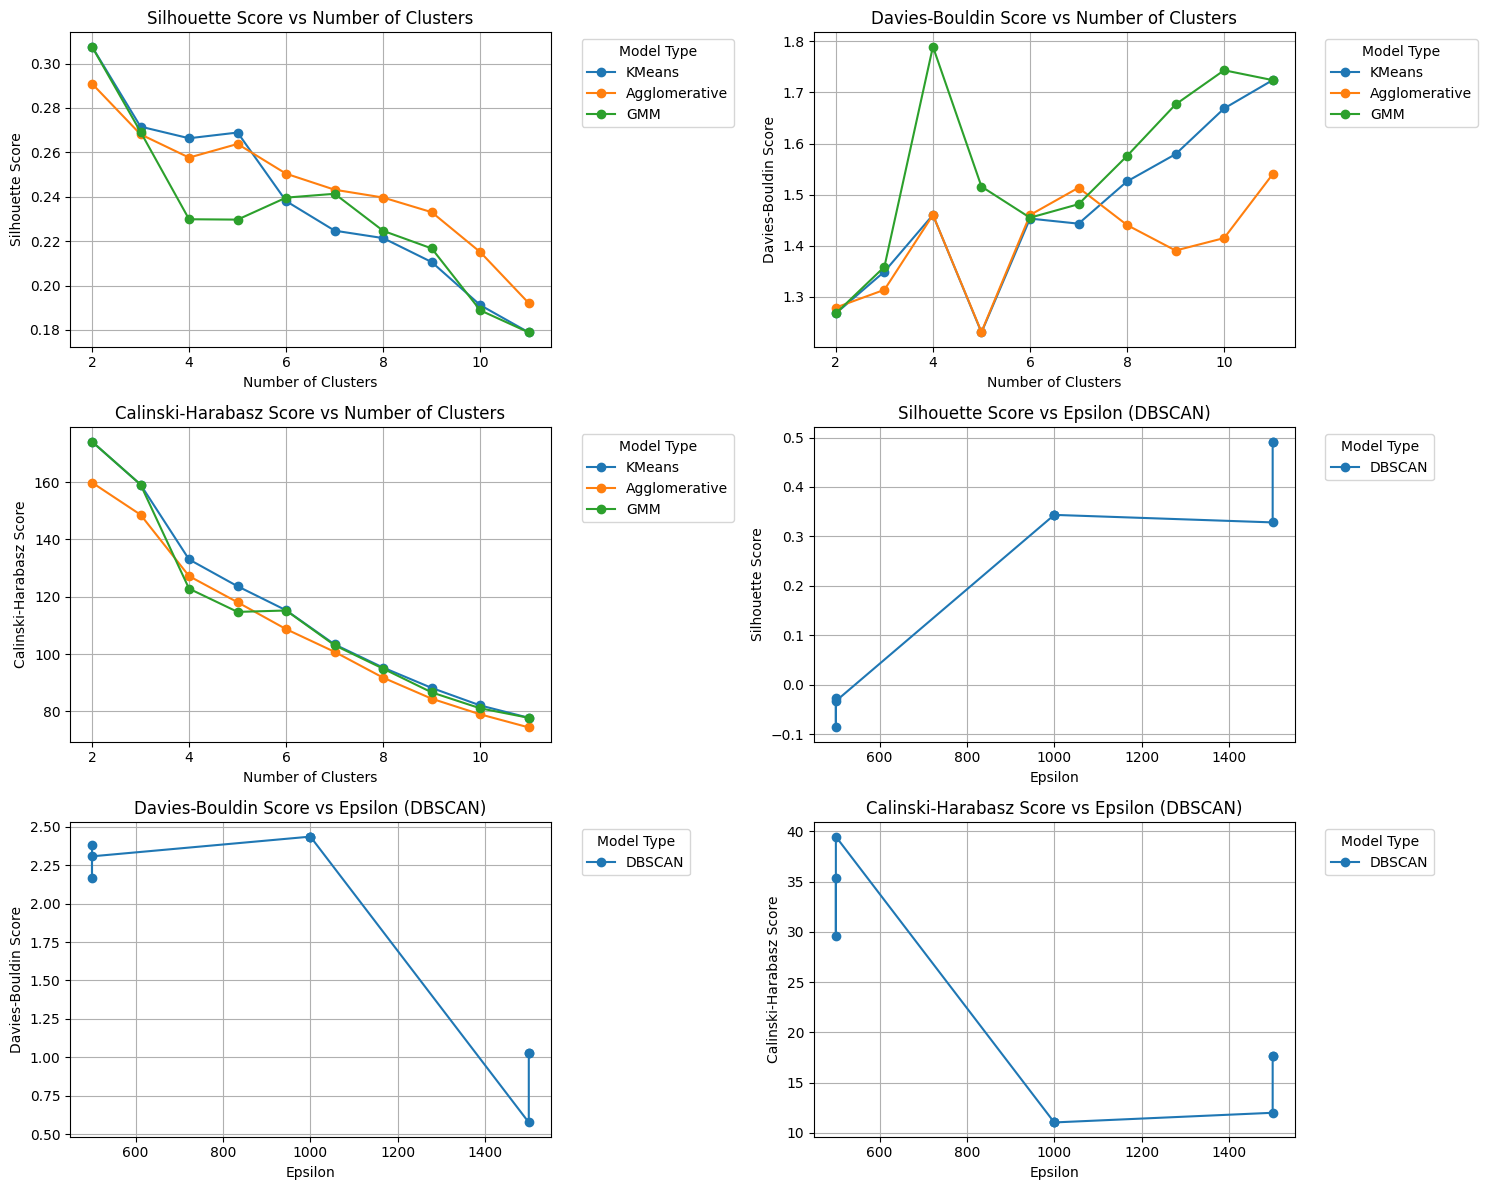

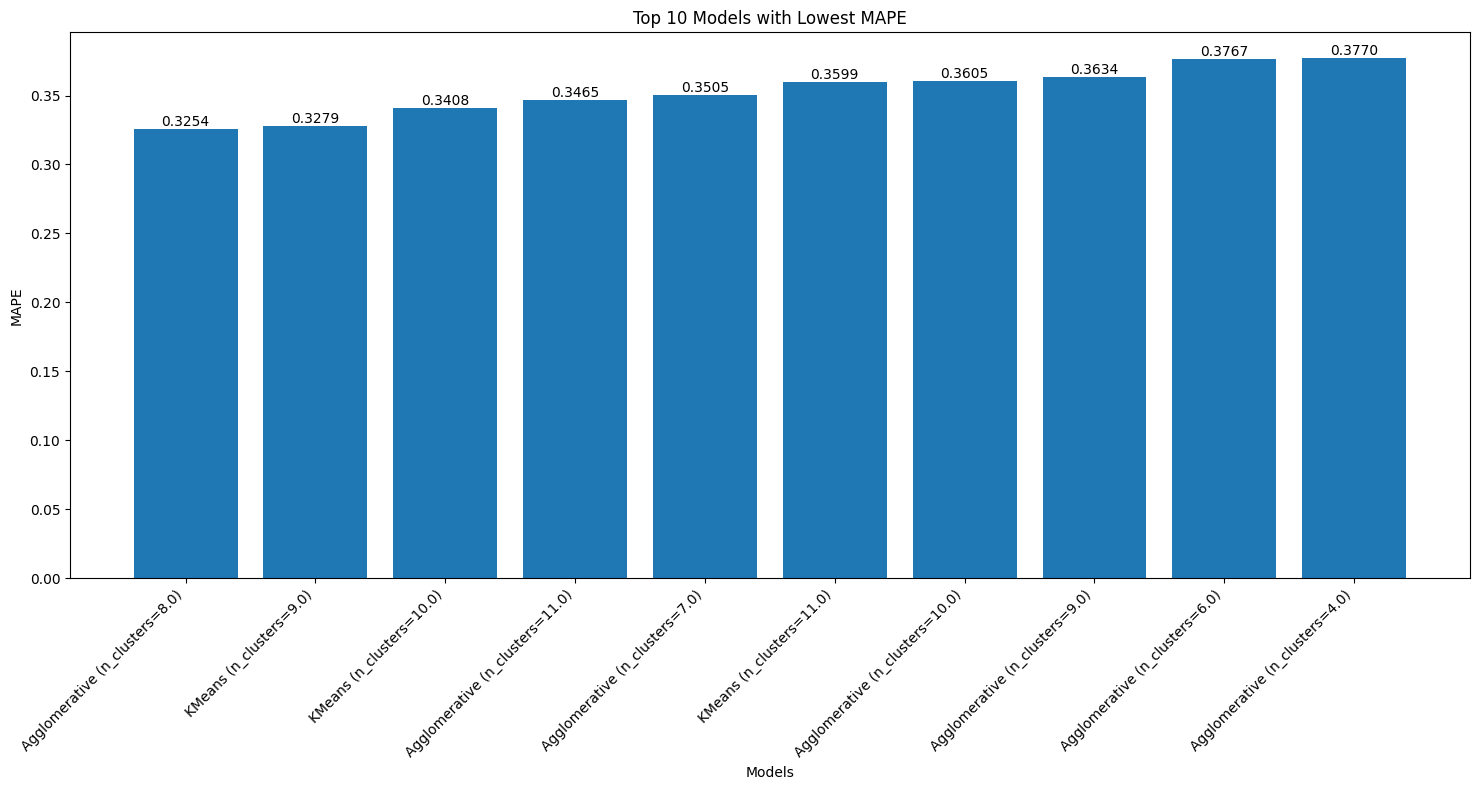

In [35]:
# Ploting Results
def plot_combined_elbow(data, x_column, y_column, title, xlabel, ylabel, subplot_position):
    plt.subplot(3, 2, subplot_position)
    for model_type in data['model_type'].unique():
        model_data = data[data['model_type'] == model_type].sort_values(x_column)
        plt.plot(model_data[x_column], model_data[y_column], marker='o', label=model_type)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)


# Combined plots for cluster-based models
cluster_models = results_df[results_df['model_type'].isin(['KMeans', 'Agglomerative', 'GMM'])]
metrics = ['Silhouette Score', 'Davies-Bouldin Score', 'Calinski-Harabasz Score']

plt.figure(figsize=(15, 12))
for i, metric in enumerate(metrics, start=1):
    plot_combined_elbow(cluster_models, 'n_clusters', metric,
                        f'{metric} vs Number of Clusters',
                        'Number of Clusters', metric, i)

# Plots for DBSCAN
dbscan_data = results_df[results_df['model_type'] == 'DBSCAN']

for i, metric in enumerate(metrics, start=4):
    plot_combined_elbow(dbscan_data, 'eps', metric,
                        f'{metric} vs Epsilon (DBSCAN)',
                        'Epsilon', metric, i)

plt.tight_layout()
plt.show()

# Create labels for each model
results_df['model_label'] = results_df.apply(lambda row: f"{row['model_type']} "
                                                         f"({'n_clusters' if row['model_type'] != 'DBSCAN' else 'eps'}="
                                                         f"{row['n_clusters'] if row['model_type'] != 'DBSCAN' else row['eps']})",
                                             axis=1)

# Sort data by MAPE in ascending order and take the top 10
sorted_data = results_df.sort_values('MAPE').head(10)

# Create bar chart for MAPE
plt.figure(figsize=(15, 8))
bars = plt.bar(range(len(sorted_data)), sorted_data['MAPE'])
plt.title('Top 10 Models with Lowest MAPE')
plt.xlabel('Models')
plt.ylabel('MAPE')
plt.xticks(range(len(sorted_data)), sorted_data['model_label'], rotation=45, ha='right')

# Add MAPE values on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()